### Requirements
`conda create -n <ENV_NAME> --file requirements.txt`

Then set kernal of this Jupter Notebook to Python in <ENV_NAME> Conda environment

### OrthoFinder
Run OrthoFinder.ipynb first

In [ ]:
import os
import glob
import pandas as pd
import requests

base_path = "pep/OrthoFinder/Results_"
species = "Astatotilapia_calliptera"
reference_species = "Danio_rerio"
go_id = "GO:0007219" # Notch signaling pathway
with open('pep/Danio_rerio.alt_ids.txt', 'r') as file:
    danio_rerio_ids = file.read().splitlines()

latest_dir = max(glob.glob(base_path + "*/"), key=os.path.getmtime)
df_orthogroups = pd.read_csv(os.path.join(latest_dir, "Orthogroups/Orthogroups.tsv"), sep='\t')
reference_group = df_orthogroups.filter(like=reference_species).columns[0]
species_group = df_orthogroups.filter(like=species).columns[0]
df_orthogroups[reference_group] = df_orthogroups[reference_group].apply(lambda x: ', '.join([gene for gene in x.split(', ') if gene not in danio_rerio_ids]))

def get_taxon_id(species):
    url = f"https://rest.ensembl.org/taxonomy/id/{species}?content-type=application/json"
    response = requests.get(url)
    if response.ok:
        data = response.json()
        return data['id']
    else:
        response.raise_for_status()

def get_genes_from_go(go_id, species):
    server = "https://www.ebi.ac.uk"
    taxon_id = get_taxon_id(species)
    genes = []
    headers = {"Content-Type": "application/json"}
    i = 1
    while True:
        ext = f"/QuickGO/services/annotation/search?goId={go_id}&taxonId={taxon_id}&limit=200&page={i}"
        response = requests.get(server + ext, headers=headers)
        if response.status_code >= 400 and response.status_code < 500:
            break
        if response.ok:
            data = response.json()
            if not data['results']:
                break
            for result in data['results']:
                url = f"https://rest.ensembl.org/xrefs/symbol/{species}/{result['geneProductId'].split(':')[1]}?content-type=application/json"
                response = requests.get(url, headers=headers)
                if response.ok:
                    xrefs = response.json()
                    for entry in xrefs:
                        if entry['type'] == 'gene':
                            if entry['id'] not in [gene['id'] for gene in genes]:
                                genes.append({
                                    'id': entry['id'],
                                    'name': result['symbol'],
                                    'qualifier': result['qualifier']
                                })
                                print(f"{result['symbol']} ({entry['id']}) {result['qualifier'].replace('_', ' ')} {go_id}")
                else:
                    response.raise_for_status()
            i += 1
        else:
            response.raise_for_status()
    return genes

go_genes = get_genes_from_go(go_id, reference_species)

df_go = df_orthogroups[df_orthogroups[reference_group].apply(lambda x: any(gene['id'] in x for gene in go_genes) if pd.notna(x) else False)]
df_go.insert(0, 'Matched_Name', df_go[reference_group].apply(lambda x: ', '.join([gene['name'] for gene in go_genes if gene['id'] in x]) if pd.notna(x) else None))
df_go.insert(1, 'Matched_ID', df_go[reference_group].apply(lambda x: ', '.join([gene['id'] for gene in go_genes if gene['id'] in x]) if pd.notna(x) else None))
df_go.insert(2, 'Matched_Qualifier', df_go[reference_group].apply(lambda x: ', '.join([gene['qualifier'] for gene in go_genes if gene['id'] in x]) if pd.notna(x) else None))
reference_counts = df_go[reference_group].apply(lambda x: str(x).count(',') if pd.notna(x) else 0)
species_counts = df_go[species_group].apply(lambda x: str(x).count(',') if pd.notna(x) else 0)
df_go.insert(3, 'Diff', species_counts - reference_counts)
df_go.to_csv("go_orthogroups.csv", index=False)

numbl (ENSDARG00000101949) acts upstream of or within GO:0007219
maml1 (ENSDARG00000076466) involved in GO:0007219
dtx3lb.2 (ENSDARG00000104649) involved in GO:0007219
bmp2k (ENSDARG00000020009) involved in GO:0007219
adam10a (ENSDARG00000053468) involved in GO:0007219
adam17a (ENSDARG00000043213) involved in GO:0007219
tet3 (ENSDARG00000062646) acts upstream of or within GO:0007219
wnt16 (ENSDARG00000110801) acts upstream of or within GO:0007219
dab2 (ENSDARG00000031761) acts upstream of or within GO:0007219
prss23 (ENSDARG00000055786) acts upstream of or within GO:0007219
zmp:0000001236 (ENSDARG00000112977) involved in GO:0007219
susd5 (ENSDARG00000088277) involved in GO:0007219
dtx3 (ENSDARG00000025766) involved in GO:0007219
aak1b (ENSDARG00000077686) involved in GO:0007219
si:ch211-194k22.8 (ENSDARG00000096711) involved in GO:0007219
neurl1aa (ENSDARG00000069438) involved in GO:0007219
si:dkey-3h3.3 (ENSDARG00000067718) involved in GO:0007219
bloc1s2 (ENSDARG00000046081) acts upst

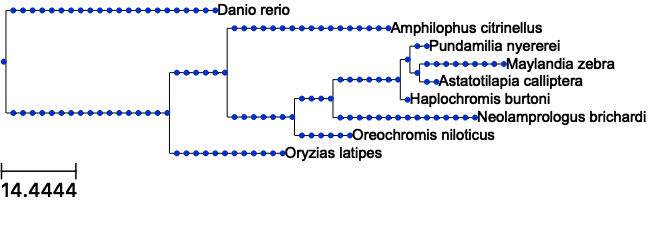

In [3]:
from ete3 import Tree, TreeStyle
import requests
from IPython.display import Image

species_list = ["Astatotilapia calliptera", "Maylandia zebra", "Oreochromis niloticus", "Danio rerio", "Amphilophus citrinellus", "Pundamilia nyererei", "Haplochromis burtoni", "Neolamprologus brichardi", "Oryzias latipes"]

def get_phylogenetic_tree(ott_ids):
    url = "https://api.opentreeoflife.org/v3/tree_of_life/induced_subtree"
    headers = {"Content-Type": "application/json"}
    data = {"ott_ids": ott_ids}
    response = requests.post(url, json=data, headers=headers)
    if response.ok:
        tree_newick = response.json().get("newick", "")
        return Tree(tree_newick, format=1)
    else:
        response.raise_for_status()

def get_ott_ids(species_list):
    url = "https://api.opentreeoflife.org/v3/tnrs/match_names"
    headers = {"Content-Type": "application/json"}
    data = {"names": species_list}
    response = requests.post(url, json=data, headers=headers)
    if response.ok:
        results = response.json().get("results", [])
        ott_ids = [result['matches'][0]['taxon']['ott_id'] for result in results if result['matches']]
        return ott_ids
    else:
        response.raise_for_status()

species_list_formatted = [species.replace('_', ' ') for species in species_list]
ott_ids = get_ott_ids(species_list_formatted)
phylo_tree = get_phylogenetic_tree(ott_ids)

for node in phylo_tree.traverse():
    if node.is_leaf():
        ott_id = int(node.name.split('_')[-1].replace('ott', ''))
        node.name = species_list[ott_ids.index(ott_id)]
species_list = [node.name for node in phylo_tree.iter_leaves()]
ts = TreeStyle()
ts.show_leaf_name = True
phylo_tree.render("tree.png", w=183, units="mm", tree_style=ts)
Image(filename="tree.png")

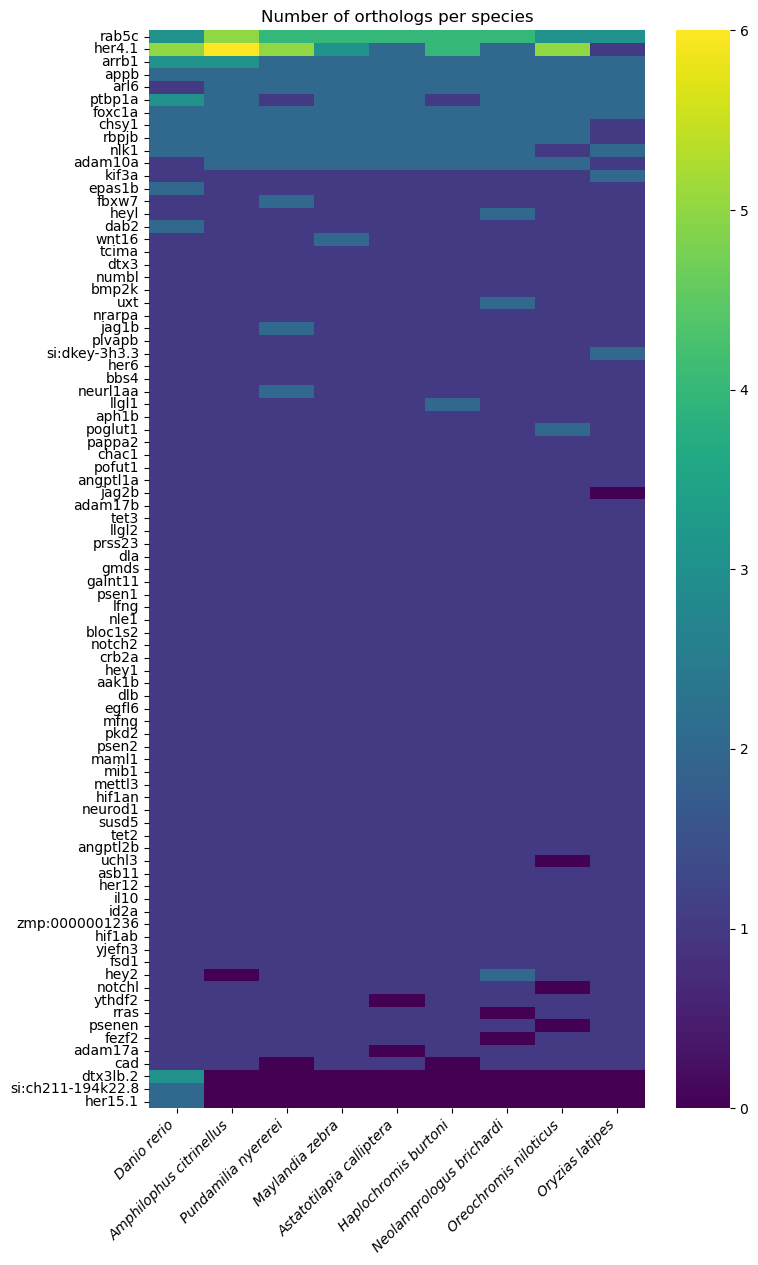

: 

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
df_go = pd.read_csv("go_orthogroups.csv")
gene_names = df_go['Matched_Name'].apply(lambda x: x.split(',')[0])
comma_count = df_go.iloc[:, 5:].map(lambda x: str(x).count(',') + 1 if pd.notna(x) else 0)
comma_count.columns = comma_count.columns.str.split('.').str[0].str.replace('_', ' ')
# species_list = ["Oryzias latipes", "Danio rerio", "Amphilophus citrinellus", "Oreochromis niloticus", "Pundamilia nyererei", "Neolamprologus brichardi", "Haplochromis burtoni", "Astatotilapia calliptera", "Maylandia zebra"]
comma_count = comma_count[species_list]
plt.figure(figsize=(8, 14))
sns.heatmap(comma_count, cmap="viridis", annot=False, fmt="d", yticklabels=gene_names)
plt.title("Number of orthologs per species")
plt.xticks(rotation=45, ha='right', fontsize=10, fontstyle='italic')
plt.show()

### Find Differential Exon Usage
Run rMATS.ipynb first

ENSACLG00000016414
ENSACLG00000010182
/ENSACLG00000010776/
ENSACLG00000011505 #Primer design failed


In [ ]:
df_csv = ("./dexseq/dexseq_results_filtered_with_norm_counts.csv", ',')
df_csv_sortedby = ["log2fold_Tropheops_Salima", 1]
df_csv_pval = 'padj'
df_csv_groupby = 'groupID'
df_csv_rm = [False, 'geneName']

In [ ]:
df_csv = ("./rmats/SE.MATS.JC.txt", '\t')
df_csv_sortedby = ["IncLevelDifference", 0.5]
df_csv_pval = 'FDR'
df_csv_groupby = 'GeneID'
df_csv_rm = [False, 'geneSymbol']

In [ ]:
df_csv = ("./rmats/MXE.MATS.JCEC.txt", '\t')
df_csv_sortedby = ["IncLevelDifference", 0.5]
df_csv_pval = 'FDR'
df_csv_groupby = 'GeneID'
df_csv_rm = [False, 'geneSymbol']

In [29]:
import pandas as pd
df_results = pd.read_csv(df_csv[0], delimiter=df_csv[1])
df_results_cleaned = df_results[df_results[df_csv_pval] < 0.05].dropna()
df_results_cleaned = df_results_cleaned[df_results_cleaned[df_csv_sortedby[0]].abs() >= df_csv_sortedby[1]]
df_results_cleaned['max'] = df_results_cleaned.groupby(df_csv_groupby)[df_csv_sortedby[0]].transform(lambda x: x.abs().max())
df_results_cleaned = df_results_cleaned.sort_values(by='max', ascending=False).drop(columns=['max'])
if df_csv_rm[0]:
    df_results_cleaned = df_results_cleaned[df_results_cleaned[df_csv_rm[1]].notna()]
df_csv[1][:df_csv[1].rfind('.')]
df_results_cleaned.to_csv(f"{df_csv[0].rsplit('.', 1)[0]}_cleaned.csv", index=False)

### Preparing Sequences

In [9]:
gene_id_list = ["ENSACLG00000010182", "ENSACLG00000016414", "ENSACLG00000011505"] # List of genes that might exhibit differential alternative splicing
primer_dict = {"ENSACLG00000010182": ["tgcagacggacatccatgag", "ccggtggcatactccatctc", "agctgcagatggacaacctg", "catgaagagaggttccccgg"]} # Annotate primers that are already designed
primer_dict["ENSACLG00000016414"] = ["CTTCGAGCTGCACGAAATCG", "GAAAGCAACGCCTGACTTGG"] # On the 9th and 9th:10th exon
primer_dict["ENSACLG00000016414"] += ["AGGTGTTTGATGGCGACGAT", "TGCTGTCTGAGACGGAAACC", "TCGCTGAAGGACGGAGGCGA"] # On the 8th, 10th, and 9th exons
exon_roi = {}
#exon_roi = {"ENSACLG00000016414": (7, 22)} # Which exons are differentially expressed, this set desgined primer pair 1:2
exon_roi = {"ENSACLG00000016414": (9, 9)} # For primer pair 3:5
#exon_roi = {"ENSACLG00000011505": (4, 6)} # Unsucessful

In [ ]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
from Bio.SeqFeature import SeqFeature, FeatureLocation
import requests
import re
import random
import os

def get_gene(gene_id):
    url = f"https://rest.ensembl.org/lookup/id/{gene_id}?expand=1"
    headers = {"Content-Type": "application/json"}
    response = requests.get(url, headers=headers)
    if not response.ok:
        response.raise_for_status()
    data = response.json()
    return data

def get_longest_transcript(gene):
    transcripts = gene.get('Transcript', [])
    if not transcripts:
        raise ValueError(f"No transcripts found for gene_id: {gene_id}")
    longest_transcript = max(transcripts, key=lambda t: t['length'])
    return longest_transcript

def get_cds(transcript_id):
    url = f"https://rest.ensembl.org/sequence/id/{transcript_id}?type=cds"
    headers = {"Content-Type": "application/json"}
    response = requests.get(url, headers=headers)
    if not response.ok:
        response.raise_for_status()
    data = response.json()
    return data.get('seq', "")

def get_sequence(seq_id):
    url = f"https://rest.ensembl.org/sequence/id/{seq_id}"
    headers = {"Content-Type": "application/json"}
    response = requests.get(url, headers=headers)
    if not response.ok:
        response.raise_for_status()
    data = response.json()
    return data.get('seq', "")

def random_color():
    return "#{:06x}".format(random.randint(0, 0xFFFFFF))

def annotate_gene(gene_id):
    gene = get_gene(gene_id)
    gene_description = gene['description'] if 'description' in gene else ""
    gene_name = gene['display_name'] + "-" if 'display_name' in gene else ""
    if not gene_description or not gene_name:
        url = f"https://rest.ensembl.org/xrefs/id/{gene_id}"
        headers = {"Content-Type": "application/json"}
        response = requests.get(url, headers=headers)
        if not response.ok:
            response.raise_for_status()
        xref_data = response.json()
        if xref_data:
            gene_name = xref_data[0]['display_id'] + "-" if 'display_id' in xref_data[0] else ""
            gene_description = xref_data[0]['description'] if 'description' in xref_data[0] else ""
    gene_name = gene_name.lower()
    gene_name_list[gene_id] = gene_name
    longest_transcript = get_longest_transcript(gene)
    longest_transcript_id = longest_transcript['id']
    longest_transcript_exons = longest_transcript['Exon']
    longest_transcript_cds = get_cds(longest_transcript_id)
    cds_seq = Seq(longest_transcript_cds)
    cds_record = SeqRecord(cds_seq, id=longest_transcript_id, description=gene_description, annotations={"molecule_type": "DNA"})
    i = 0
    if gene_id in exon_roi:
        roi_start, roi_end = exon_roi[gene_id]
        print(f"Gene: {gene_name}{gene_id}, ROI: Exon{roi_start} to {roi_end}")
        roi[gene_id] = {'ROI_len':"", 'ROI_flank_len':"", 'ROI_seq':"", 'ROI_flank_seq':""}
    strand = longest_transcript['strand']
    for exon in longest_transcript_exons:
        if strand == 1:
            if i == 0:
                exon_start = 0
                exon_end = exon['end'] - longest_transcript['Translation']['start'] + 1
            else:
                exon_start = exon_end_last
                exon_end = exon_start + exon['end'] - exon['start'] + 1
        else:
            if i == 0:
                exon_start = 0
                exon_end = longest_transcript['Translation']['end'] - exon['start'] + 1
            else:
                exon_start = exon_end_last
                exon_end = exon_start + exon['end'] - exon['start'] + 1
        exon_end_last = exon_end
        exon_feature = SeqFeature(FeatureLocation(exon_start, exon_end, strand=strand), type="exon", id=exon['id'])
        exon_feature.qualifiers['label'] = f"{i+1}:{exon['id']}"
        exon_feature.qualifiers['ApEinfo_fwdcolor'] = random_color()
        cds_record.features.append(exon_feature)
        i += 1
        if gene_id in roi:
            if roi_start - 2 <= i <= roi_end + 2:
                roi[gene_id]['ROI_flank_seq'] += str(cds_seq[exon_start:exon_end])
            if roi_start <= i <= roi_end:
                roi[gene_id]['ROI_seq'] += str(cds_seq[exon_start:exon_end])
    if gene_id in roi:
        roi[gene_id]['ROI_len'] = len(roi[gene_id]['ROI_seq'])
        roi[gene_id]['ROI_flank_len'] = len(roi[gene_id]['ROI_flank_seq'])
    if gene_id in primer_dict:
        for primer in primer_dict[gene_id]:
            matches = [match.start() for match in re.finditer(primer, str(cds_seq), re.IGNORECASE)]
            if matches:
                for match in matches:
                    primer_feature = SeqFeature(FeatureLocation(match, match + len(primer)), type="primer", id=primer)
                    primer_feature.qualifiers['label'] = f"primer{primer_dict[gene_id].index(primer)+1}:{primer}"
                    primer_feature.qualifiers['ApEinfo_fwdcolor'] = random_color()
                    cds_record.features.append(primer_feature)
            rev_primer = str(Seq(primer).reverse_complement())
            rev_matches = [match.start() for match in re.finditer(rev_primer, str(cds_seq), re.IGNORECASE)]
            if rev_matches:
                for match in rev_matches:
                    primer_feature = SeqFeature(FeatureLocation(match, match + len(rev_primer), strand=-1), type="primer", id=rev_primer)
                    primer_feature.qualifiers['label'] = f"primer{primer_dict[gene_id].index(primer)+1}:{primer}"
                    primer_feature.qualifiers['ApEinfo_fwdcolor'] = random_color()
                    cds_record.features.append(primer_feature)
    output_folder = f"./{gene_name}{gene_id}"
    output_path = os.path.join(output_folder, f"{longest_transcript_id}.ape")
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    with open(output_path, "w") as output_handle:
        SeqIO.write(cds_record, output_handle, "genbank")

gene_name_list = {}
roi = {}
for gene_id in gene_id_list:
    annotate_gene(gene_id)

Gene: dgkq-ENSACLG00000016414, ROI: Exon9 to 9


### Designing Primers

In [ ]:
design_internal_primer = True
pcr_product_size_range = [[30, 1000]]
genome = "Astatotilapia_calliptera.fAstCal1.3.113"
email = "your.email@example.com"
species = " ".join(genome.split(".")[0].split("_")[:2])

In [ ]:
annotaion_file = f"./genome/{genome}.gtf"
genome_file = f"./genome/{genome.rsplit('.', 1)[0]}.dna_sm.toplevel.fa"
blast_db = f"./blastdb/{genome}"

import primer3
import pandas as pd
from Bio.Blast import NCBIXML
from Bio.Blast import NCBIWWW
from Bio import Entrez
Entrez.email = email

def get_ensembl_id_from_ncbi_id(ncbi_id):
    url = f"https://mygene.info/v3/query?q={ncbi_id}&fields=ensembl.gene"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        if 'hits' in data and len(data['hits']) > 0:
            ensembl_id = data['hits'][0].get('ensembl', {}).get('gene')
            return ensembl_id
    return None

def get_absolute_position(ensembl_id):
    url = f"https://rest.ensembl.org/lookup/id/{ensembl_id}?expand=1"
    headers = {"Content-Type": "application/json"}
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        data = response.json()
        if 'seq_region_name' in data and 'start' in data and 'end' in data:
            chrom = data['seq_region_name']
            start = data['start']
            end = data['end']
            absolute_position = f"{chrom}:{start:,}-{end:,}"
            return absolute_position
    return None

def handle_blast_record(blast_record):
    results = []
    for alignment in blast_record.alignments:
        for hsp in alignment.hsps:
            ncbi_id = alignment.title.split('|')[3]
            gene_id = get_ensembl_id_from_ncbi_id(ncbi_id)
            position = get_absolute_position(gene_id) if gene_id else ""
            results.append({
                'ID': gene_id if gene_id else alignment.title.split('|')[1],
                'Position': position if position else alignment.title.split('|')[3],
                'Title': alignment.title.split(':')[1],
                'Length': alignment.length,
                'E-value': hsp.expect,
                'Score': hsp.score,
                'Query Start': hsp.query_start,
                'Query End': hsp.query_end,
                'Subject Start': hsp.sbjct_start,
                'Subject End': hsp.sbjct_end,
                'Identities': hsp.identities,
                'Gaps': hsp.gaps,
                'Positives': hsp.positives,
                'Query Sequence': hsp.query,
                'Subject Sequence': hsp.sbjct
            })
    return pd.DataFrame(results)

def parse_blast_xml(xml_file):
    with open(xml_file) as handle:
        blast_record = NCBIXML.read(handle)
    return handle_blast_record(blast_record)

def blastn(sequence, output_file):
    result_handle = NCBIWWW.qblast("blastn", "nt", sequence, entrez_query=f"{species}[ORGN]")
    with open(output_file, "w") as out_handle:
        out_handle.write(result_handle.read())
    result_handle.close()

def get_primers(data):
    roi_len = data['ROI_len']
    roi_flank_seq = data['ROI_flank_seq']
    roi_seq = data['ROI_seq']
    exclude_roi = False
    if any(lower <= roi_len <= upper for lower, upper in pcr_product_size_range):
        sequence = roi_flank_seq
        exclude_roi = True
        start_pos = roi_flank_seq.find(roi_seq)
        print(f"ROI length: {roi_len}, using flanking sequence")
    else:
        sequence = roi_seq
        print(f"ROI length: {roi_len}, using ROI sequence")
    seq_args = {
        'SEQUENCE_TEMPLATE': sequence,
    }
    global_args = {
        'SEQUENCE_EXCLUDED_REGION': [[start_pos, roi_len]] if exclude_roi else [],
        'SEQUENCE_INTERNAL_EXCLUDED_REGION': [[1, start_pos - 1], [start_pos + roi_len, len(sequence) - start_pos - roi_len]] if exclude_roi else [],
        'PRIMER_PICK_INTERNAL_OLIGO': 1 if design_internal_primer else 0,
        'PRIMER_OPT_SIZE': 20,
        'PRIMER_INTERNAL_MAX_SELF_END': 8,
        'PRIMER_MIN_SIZE': 18,
        'PRIMER_MAX_SIZE': 27,
        'PRIMER_OPT_TM': 60.0,
        'PRIMER_MIN_TM': 57.0,
        'PRIMER_MAX_TM': 63.0,
        'PRIMER_OPT_GC_PERCENT': 50.0,
        'PRIMER_MIN_GC': 20.0,
        'PRIMER_MAX_GC': 80.0,
        'PRIMER_MAX_POLY_X': 5,
        'PRIMER_INTERNAL_MAX_POLY_X': 5,
        'PRIMER_SALT_MONOVALENT': 50.0,
        'PRIMER_SALT_DIVALENT': 1.5,
        'PRIMER_DNA_CONC': 50.0,
        'PRIMER_MAX_NS_ACCEPTED': 0,
        'PRIMER_MAX_SELF_ANY': 8,
        'PRIMER_MAX_SELF_END': 3,
        'PRIMER_PAIR_MAX_COMPL_ANY': 8,
        'PRIMER_PAIR_MAX_COMPL_END': 3,
        'PRIMER_PRODUCT_SIZE_RANGE': pcr_product_size_range,
        'PRIMER_NUM_RETURN': 5
    }
    primers = primer3.bindings.design_primers(seq_args, global_args)
    return primers

for gene_id, data in roi.items():
    records = []
    path = f"./{gene_name_list[gene_id]}{gene_id}"
    primers = get_primers(data)
    with open(f"{path}/Primer_summary.txt", "a") as summary_file:
        summary_file.write(f"Primers for {gene_id}:")
        print(f"Primers for {gene_id}:")
        for i in range(primers['PRIMER_LEFT_NUM_RETURNED']):
            left_primer_seq = Seq(primers[f'PRIMER_LEFT_{i}_SEQUENCE'])
            right_primer_seq = Seq(primers[f'PRIMER_RIGHT_{i}_SEQUENCE'])
            if design_internal_primer: internal_primer_seq = Seq(primers[f'PRIMER_INTERNAL_{i}_SEQUENCE'])
            summary_file.write(f"Primer Pair {i+1}:\n")
            summary_file.write(f"  Left Primer: {left_primer_seq}\n")
            summary_file.write(f"  Right Primer: {right_primer_seq}\n")
            if design_internal_primer: summary_file.write(f"  Internal Primer: {internal_primer_seq}\n")
            print(f"Primer Pair {i+1}:")
            print(f"  Left Primer: {left_primer_seq}")
            print(f"  Right Primer: {right_primer_seq}")
            if design_internal_primer: print(f"  Internal Primer: {internal_primer_seq}")
            records.append(SeqRecord(left_primer_seq, id=f"{i+1}L", description=""))
            records.append(SeqRecord(right_primer_seq, id=f"{i+1}R", description=""))
            if design_internal_primer:
                records.append(SeqRecord(internal_primer_seq, id=f"{i+1}I", description=""))
                array = [('L', left_primer_seq), ('R', right_primer_seq), ('I', internal_primer_seq)]
            else:
                array = [('L', left_primer_seq), ('R', right_primer_seq)] 
            for primer_type, primer_seq in array:
                result_file = f"./{path}/Primer{i+1}{primer_type}_blast.xml"
                blastn(str(primer_seq), result_file)
                blast_df = parse_blast_xml(result_file)
                for idx, row in blast_df.iterrows():
                    if row['ID'] == gene_id:
                        blast_df = blast_df.drop(idx)
                if not blast_df.empty:
                    summary_file.write(f"{primer_type} Primer BLAST Results:\n")
                    summary_file.write(f"  Number of alignments: {len(blast_df)}\n")
                    summary_file.write(f"  Top hit: {blast_df.iloc[0]['Position']} {blast_df.iloc[0]['ID']} {blast_df.iloc[0]['Title']}, E-value: {blast_df.iloc[0]['E-value']}\n")
                    print(f"{primer_type} Primer BLAST Results:")
                    print(f"  Number of alignments: {len(blast_df)}")
                    print(f"  Top hit: {blast_df.iloc[0]['Position']} {blast_df.iloc[0]['ID']} {blast_df.iloc[0]['Title']}, E-value: {blast_df.iloc[0]['E-value']}")
                else:
                    summary_file.write(f"{primer_type} Primer BLAST Results: No hits found\n")
                    print(f"{primer_type} Primer BLAST Results: No hits found")
                blast_df.to_csv(f"./{path}/Primer{i+1}{primer_type}_blast.csv", index=False)
                left_blast_df = pd.read_csv(f"./{path}/Primer{i+1}L_blast.csv")
                right_blast_df = pd.read_csv(f"./{path}/Primer{i+1}R_blast.csv")
                common_hits = pd.merge(left_blast_df, right_blast_df, on='ID', suffixes=('', '_right'), how='outer')
                if design_internal_primer:
                    internal_blast_df = pd.read_csv(f"./{path}/Primer{i+1}I_blast.csv")
                    common_hits = pd.merge(common_hits, internal_blast_df, on='ID', suffixes=('', '_internal'))
                    common_hits = common_hits.drop_duplicates(subset=['ID']).reset_index(drop=True)
                summary_file.write(f"Common Hits for Primer Pair {i+1}:\n")
                summary_file.write(f"  Number of common hits: {len(common_hits)}\n")
                if not common_hits.empty:
                    for index, row in common_hits.iterrows():
                        summary_file.write(f"  Hit {index+1}: {row['Position']} {row['ID']} {row['Title']}, E-value: {row['E-value']}\n")
                print(f"Common Hits for Primer Pair {i+1}:")
                print(f"  Number of common hits: {len(common_hits)}")
                if not common_hits.empty:
                    for index, row in common_hits.iterrows():
                        print(f"  Hit {index+1}: {row['Position']} {row['ID']} {row['Title']}, E-value: {row['E-value']}")
                common_hits.to_csv(f"./{path}/Primer{i+1}_common_hits.csv", index=False)
    SeqIO.write(records, f"{path}/Primers.fa", "fasta")

ROI length: 215, using flanking sequence
Primers for ENSACLG00000016414:
Primer Pair 1:
  Left Primer: AGGTGTTTGATGGCGACGAT
  Right Primer: TGCTGTCTGAGACGGAAACC
  Internal Primer: TCGCTGAAGGACGGAGGCGA
L Primer BLAST Results:
  Number of alignments: 15
  Top hit: 2:10,450,246-10,478,221 ENSACLG00000016414  Astatotilapia calliptera diacylglycerol kinase theta (dgkq), transcript variant X1, mRNA, E-value: 0.00342527
R Primer BLAST Results:
  Number of alignments: 13
  Top hit: 2:10,450,246-10,478,221 ENSACLG00000016414  Astatotilapia calliptera diacylglycerol kinase theta (dgkq), transcript variant X1, mRNA, E-value: 0.00342527
I Primer BLAST Results:
  Number of alignments: 25
  Top hit: 2:10,450,246-10,478,221 ENSACLG00000016414  Astatotilapia calliptera diacylglycerol kinase theta (dgkq), transcript variant X1, mRNA, E-value: 0.00342526
Common Hits for Primer Pair 1:
  Number of common hits: 1
  Hit 1: 2:10,450,246-10,478,221 ENSACLG00000016414  Astatotilapia calliptera diacylglycerol 

KeyboardInterrupt: 

### Backup Scripts

ENSACLG00000004087 E002
ENSACLG00000026087 E008?
ENSACLG00000012728 E001?
ENSACLG00000020646 E004
ENSACLG00000011505 E012
ENSACLG00000003876 E042
ENSACLG00000025257 E012/
ENSACLG00000002025 E014/
**ENSACLG00000016414 E015**
**ENSACLG00000015604 E005**
**ENSACLG00000010182 E020**
**ENSACLG00000018072 E002**
**ENSACLG00000021184 E002**
**ENSACLG00000027919 E018**
**ENSACLG00000016414 E017**
**ENSACLG00000003858 E006**
**ENSACLG00000022676 E004**
**ENSACLG00000015604 E002**
**ENSACLG00000018499 E005**
**ENSACLG00000009499 E001**
**ENSACLG00000015133 E018**
**ENSACLG00000010075 E011**
ENSACLG00000000969
ENSACLG00000004086
ENSACLG00000019020
ENSACLG00000003013
**ENSACLG00000024008**
ENSACLG00000009059
**ENSACLG00000002869**
ENSACLG00000021745
ENSACLG00000027444\*
ENSACLG00000008688
ENSACLG00000004444
ENSACLG00000015800 TP


In [ ]:
"""
import subprocess

packages_to_install = ['numpy', 'pandas', 'pingouin', 'patchworklib', 'plotnine', 'scikit-posthocs', 'statsmodels']
env_name = 'biopython'

for package in packages_to_install:
    subprocess.run(['conda', 'install', '-n', env_name, package, '-y'])
""" 
# gtf_columns = [
#     'seqname', 'source', 'feature', 'start', 'end',
#     'score', 'strand', 'frame', 'attribute'
# ]
# gtf_df = pd.read_csv(
#     annotaion_file, 
#     sep='\t', 
#     comment='#', 
#     header=None, 
#     names=gtf_columns
# )
# genes_df = gtf_df[gtf_df['feature'] == 'gene']
# #import re
# def parse_attributes(attribute_string):
#     attrs = {}
#     for attr in attribute_string.split(';'):
#         if attr.strip() == '':
#             continue
#         key, value = attr.strip().split(' ', 1)
#         attrs[key] = value.replace('"', '')
#     return attrs
# attributes = genes_df['attribute'].apply(parse_attributes)
# attributes_df = pd.json_normalize(attributes)
# genes_df = genes_df.join(attributes_df)
# print(genes_df.head())
# blast_df = parse_blast_xml("blast_results.xml")
# print(blast_df.head())
# # Merge BLAST results with gene annotations
# # Assuming 'Hit ID' corresponds to gene IDs in the GTF file, adjust as necessary
# merged_df = blast_df.merge(
#     genes_df, 
#     left_on='Hit ID', 
#     right_on='gene_id', 
#     how='left'
# )
# print(merged_df.head())
# Save merged results to CSV for user-friendly viewing
# merged_df.to_csv("merged_blast_annotations.csv", index=False)

# with open(output_file) as result_handle:
#     blast_record = NCBIXML.read(result_handle)
# for alignment in blast_record.alignments:
#     for hsp in alignment.hsps:
#         print(f"****Alignment****")
#         print(f"Sequence: {alignment.title}")
#         print(f"Length: {alignment.length}")
#         print(f"e-value: {hsp.expect}")
#         print(hsp.query)
#         print(hsp.match)
#         print(hsp.sbjct)
    # if not enable_online_blast:
    #     blastn(f"{path}/Primers.fa", f"{path}/Primers_blast.xml")
    #     with open(f"{path}/Primers_blast.xml") as result_handle:
    #         blast_records = NCBIXML.parse(result_handle)
    #         for blast_record in blast_records:
    #             print(f"Query: {blast_record.query}")
# if enable_online_blast:
#     from Bio import Entrez
#     from Bio.Blast import NCBIWWW
#     Entrez.email = email
#     def blastn(sequence, output_file):
#         result_handle = NCBIWWW.qblast("blastn", "nt", sequence, entrez_query=f"{species}[ORGN]")
#         with open(output_file, "w") as out_handle:
#             out_handle.write(result_handle.read())
#         result_handle.close()
# else:
#     if not os.path.exists(os.path.dirname(blast_db)):
#         os.makedirs(os.path.dirname(blast_db))
#     if not any(fname.endswith(".ndb") for fname in os.listdir(os.path.dirname(blast_db))):
#         import urllib.request
#         import re
#         blast_db_url = "https://ftp.ensembl.org/pub/current_ncbi_blast/genomic/"
#         file_pattern = f"{species.replace(' ', '_')}.*.dna_sm.toplevel.fa.*"
#         file_pattern = re.compile(file_pattern.replace(".", r"\.").replace("*", ".*").replace("?", "."))
#         with urllib.request.urlopen(blast_db_url) as response:
#             html = response.read().decode('utf-8')
#             file_list = re.findall(r'href="([^"]+)"', html)
#         for file in file_list:
#             if file_pattern.match(file):
#                 file_url = f"{blast_db_url}{file}"
#                 print(f"Downloading {file_url}")
#                 local_file = os.path.join(os.path.dirname(blast_db), file)
#                 blast_db = os.path.splitext(local_file)[0]
#                 urllib.request.urlretrieve(file_url, local_file)
#         if not any(fname.endswith(".ndb") for fname in os.listdir(os.path.dirname(blast_db))):
#             if not os.path.exists(blast_db + ".asnb"):
#                 subprocess.run(['convert2blastmask', '-in', genome_file, '-parse_seqids', '-masking_algorithm', 'repeat', '-masking_options', 'repeatmasker', '-outfmt', 'maskinfo_asn1_bin', '-out', f'{blast_db}.asnb'], check=True)
#             subprocess.run(['makeblastdb', '-in', genome_file, '-dbtype', 'nucl', '-mask_data', f'{blast_db}.asnb', '-parse_seqids', '-title', species, '-out', blast_db], check=True)
#     blast_db = os.path.splitext(next(fname for fname in os.listdir(os.path.dirname(blast_db)) if fname.endswith(".ndb")))[0]
#     def blastn(blast_query, output_file):
#         subprocess.run(['blastn', '-query', blast_query, '-db', blast_db, '-out', output_file, '-outfmt', '5', '-evalue', '1e-6'], check=True)


In [ ]:
# import webbrowser
# df_results_group_counts = df_results_cleaned[df_csv_groupby].value_counts().sort_values(ascending=False)
# df_results_group_max = df_results_group_counts[df_results_group_counts == df_results_group_counts.max()].index.tolist()
# df_results_group_counts.to_csv("df_results_cleaned_onlyID.csv", header=True)
# for gene_id_list in df_results_group_max:
#     webbrowser.open_new("https://www.ensembl.org/id/" + gene_id)

### Bulk RNA Seq Analysis
Run `./Salmon` first